In [1]:
# Import only the packages necessary to check if FEFLOW and ifm_contrib is present
import sys
import os

# Check the current operating system
if sys.platform == 'win32':  # For Windows use \\, for Linux use /
    sys.path.append('C:\\Program Files\\DHI\\2025\\FEFLOW 10.0\\python')
    os.environ['FEFLOW10_ROOT'] = 'C:\\Program Files\\DHI\\2025\\FEFLOW 10.0\\'
    os.environ['FEFLOW_KERNEL_VERSION'] = '10'  # Modify for your use e.g. FEFLOW 7.4 would be 74
elif sys.platform == 'linux':
    sys.path.append('/opt/feflow/10.0/python/')
    os.environ['FEFLOW10_ROOT'] = '/opt/feflow/10.0/'
    os.environ['FEFLOW_KERNEL_VERSION'] = '10'  # Modify for your use e.g. FEFLOW 7.4 would be 74
else:
    sys.exit("Unsupported operating system.")
# Try to import the ifm package
try:
    from ifm import Enum
    import ifm_contrib as ifm
except ModuleNotFoundError:
    sys.exit("ifm_contrib could not be imported.")
# Check which version of FEFLOW is being used, modify for your use e.g. FEFLOW 7.4 would be 7400
if ifm.getKernelVersion() < 8000:
    sys.exit("This script is designed for FEFLOW version 8 and higher.")

# Import the rest of the required packages
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
# Define the location of the FEFLOW FEM file
INPUT_FEM = os.path.join(os.path.join(os.getcwd(), "fem"), "BaseModel.fem")
# Create the variable to load the FEM file
doc = None
loaded = False
# Create a variable to track the number of reconnection attempts
reconnection_attempts = 0

# Attempt to load the FEM file
while not loaded:
    try:
        # Load the FEFLOW model
        doc = ifm.loadDocument(INPUT_FEM)
        # Set the boolean to true for success
        loaded = True
    except ConnectionError:
        # Print an error message
        print("Failed to establish a connection to the FEFLOW license server.")
        # Check how many reconnection attempts have been made
        if reconnection_attempts > 3:
            sys.exit(f"Failed to establish a connection to the FEFLOW license server after {reconnection_attempts} attempts.")
        else:
            # Wait and retry
            time.sleep(300)
            reconnection_attempts += 1
    except FileNotFoundError:
        # Exit the program
        sys.exit("Failed to find the specified FEFLOW model.")

In [3]:
# In regular IFM we can query the number of selections per geometry type
print(f"# of selections: {doc.getNumberOfSelections(Enum.SEL_ELEMS)}")
# To find the index of a selection with a known name, use:
index = doc.findSelection(Enum.SEL_ELEMS, "sandstone")
# Which can in turn be used in various functions, such as getting the number of elements in this selection
print(f"# of elements in selection: {doc.getSelectionItemCount(Enum.SEL_ELEMS, index)}")

# of selections: 3
# of elements in selection: 31288


In [4]:
# ifm_contrib provides many productive enhancements to ifm, such as
doc.c.sel.df.selections(seltype=Enum.SEL_ELEMS)
# ifm_contrib tends to be the best way to access data and results

,SEL_TYPE,SEL_ENUM,SEL_ID,N_ITEMS
selection_name,,,,
sandstone,elements,1,0,31288
basalt,elements,1,1,71592
Pit,elements,1,2,454


In [5]:
# We can also get the nodal selections
doc.c.sel.df.selections(seltype=Enum.SEL_NODES)

,SEL_TYPE,SEL_ENUM,SEL_ID,N_ITEMS
selection_name,,,,
bcNorthBorder,nodes,0,0,565
bcSouthBorder,nodes,0,1,425
SpillSite,nodes,0,2,642


In [6]:
# Example on element activation/deactivation
# Deactivate some elements
for element in doc.getSelectionItems(Enum.SEL_ELEMS, 2):
    doc.setMatElementActive(element, 0)  # Second parameter: 0 = Inactive, 1 = Active

In [7]:
# Now, using these selections, let's set up BCs
# BC Types:
# Enum.BC_NONE (0) = no boundary condition (delete existing)
# Enum.BC_DIRICHLET (1) = Dirichlet (1st kind)
# Enum.BC_NEUMANN (2) = Neumann (2nd kind)
# Enum.BC_CAUCHY (3) = Cauchy (3rd kind)
# Enum.BC_SINGLE_WELL (4) = Single well (4th kind)
# Enum.BC_GRADIENT_FTYPE (5) = Gradient-type

# Define parameters to assign heads
initial_head = 0
selection_count = 0
value = 30

for selection_id in range(doc.getNumberOfSelections(Enum.SEL_NODES)):
    selection = doc.getSelectionItems(Enum.SEL_NODES, selection_id)
    selection_name = doc.getSelectionName(Enum.SEL_NODES, selection_id)
    if selection_name.startswith("bc"):
        print(f"Setting {doc.getSelectionName(Enum.SEL_NODES, selection_id)} to {value}")
        # Create constant head BC for each node in the selection
        for selected_node in selection:
            # Params: Node, BC-Type (see above), Steady-state/Transient (0/1), BC Value (Can be timeseries for transient)
            doc.setBcFlowTypeAndValueAtCurrentTime(selected_node, 1, 0, value)
        initial_head += value
        value -= 10
        selection_count += 1

Setting bcNorthBorder to 30
Setting bcSouthBorder to 20


In [8]:
# Calculate initial head
initial_head = initial_head / selection_count
print(f"Initial head value: {initial_head}")
# Now let's add initial head values to guide the solution
for node in range(doc.getNumberOfNodes()):
    doc.setParamValue(Enum.P_HEAD, node, initial_head)

Initial head value: 25.0


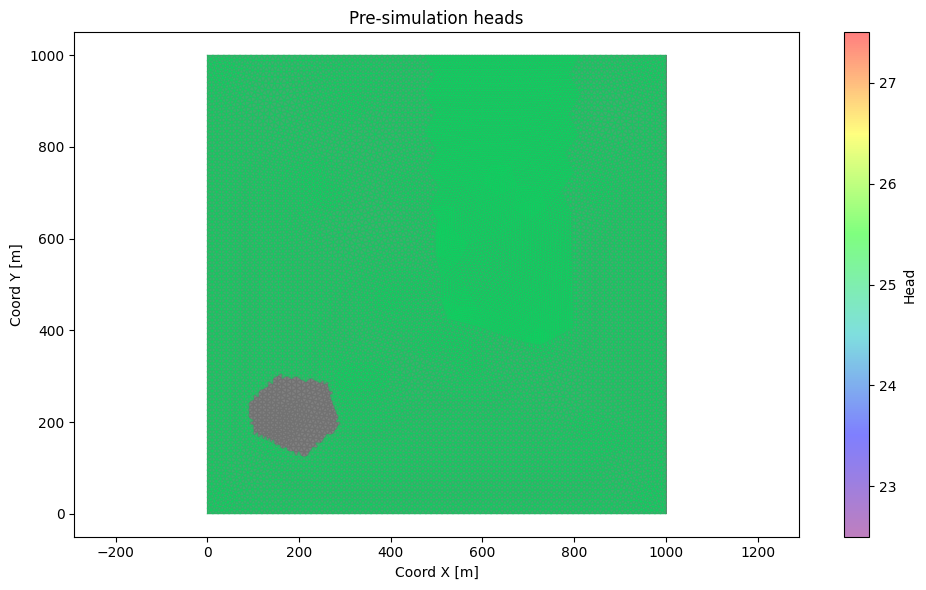

In [9]:
# Now to visualise and inspect what we just did
# Create a new matplotlib figure
fig, ax = plt.subplots(1, figsize=(10, 6))
# Set equal x and y axis
plt.axis("equal")

# Add the mesh (faces and edges)
doc.c.plot.faces()
doc.c.plot.edges(alpha=0.1)
# Plot the parameter (NOTE: for nodal use fringes/continuous)
doc.c.plot.continuous(par=Enum.P_HEAD, slice=1, alpha=0.5)

# Add colorbar, title and axis labels
cbar = plt.colorbar()
cbar.set_label('Head', rotation=90)
plt.title("Pre-simulation heads")
plt.xlabel("Coord X [m]")
plt.ylabel("Coord Y [m]")

plt.tight_layout()

# Save and plot
plt.savefig(os.path.join(os.path.join(os.getcwd(), "output"), "PreSimHeads.png"))
plt.show()

In [10]:
for selection_id in range(doc.getNumberOfSelections(Enum.SEL_ELEMS)):
    selection = doc.getSelectionItems(Enum.SEL_ELEMS, selection_id)
    selection_name = doc.getSelectionName(Enum.SEL_ELEMS, selection_id)
    if selection_name == "sandstone":
        kxy = 5E-1
        kz = 5E-2
        poro = 0.1
        print(f"Setting {doc.getSelectionName(Enum.SEL_ELEMS, selection_id)} Kxy to {kxy}, Kz to {kz}")
        # Create constant head BC for each node in the selection
        for selected_element in selection:
            doc.setParamValue(Enum.P_CONDX, selected_element, kxy)
            doc.setParamValue(Enum.P_CONDY, selected_element, kxy)
            doc.setParamValue(Enum.P_CONDZ, selected_element, kz)
    elif selection_name == "basalt":
        kxy = 2E-2
        kz = 5E-4
        poro = 0.05
        print(f"Setting {doc.getSelectionName(Enum.SEL_ELEMS, selection_id)} Kxy to {kxy}, Kz to {kz}")
        # Create constant head BC for each node in the selection
        for selected_element in selection:
            doc.setParamValue(Enum.P_CONDX, selected_element, kxy)
            doc.setParamValue(Enum.P_CONDY, selected_element, kxy)
            doc.setParamValue(Enum.P_CONDZ, selected_element, kz)

Setting sandstone Kxy to 0.5, Kz to 0.05
Setting basalt Kxy to 0.02, Kz to 0.0005


In [11]:
# Set the solver to direct (steady-state)
doc.setEquationSolvingType(Enum.EQSOLV_DIRECT)
# We can then save the file
doc.saveDocument(os.path.join(os.path.join(os.getcwd(), "fem"), "ModelMod.fem"))

# Perform steady-state simulation
print(f"Starting steady state simulation.")
doc.startSimulator()
doc.stopSimulator()
print(f"Steady state simulation completed.")

# Save the results
doc.saveDocument(os.path.join(os.path.join(os.getcwd(), "fem"), "ModelModSteady.fem"))

Starting steady state simulation.
Steady state simulation completed.


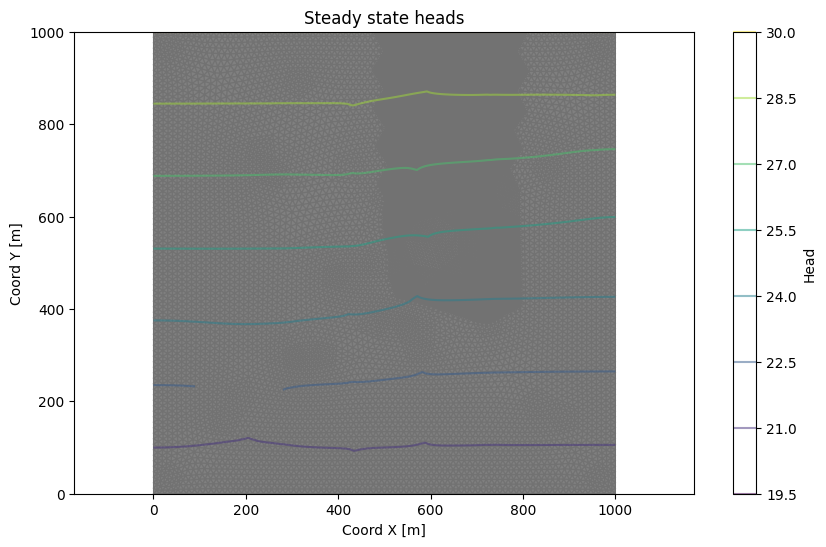

In [12]:
# Now visualise and inspect the steady state solution
# Create a new matplotlib figure
fig, ax = plt.subplots(1, figsize=(10,6))
# Set equal x and y axis
plt.axis("equal")

# Add the mesh (faces and edges)
doc.c.plot.faces()
doc.c.plot.edges(alpha=0.1)
# Plot the parameter (NOTE: for nodal use fringes/continuous)
doc.c.plot.isolines(par=Enum.P_HEAD, slice=1, alpha=0.5)

# Add colorbar, title and axis labels
cbar = plt.colorbar()
cbar.set_label('Head', rotation=90)
plt.title("Steady state heads")
plt.xlabel("Coord X [m]")
plt.ylabel("Coord Y [m]")

# Save and plot
plt.savefig(os.path.join(os.path.join(os.getcwd(), "output"), "SteadySimHeads.png"))
plt.show()

Let's prepare for a transient multi-species mass transport calculation

In [13]:
# First, what species do we have:
l_species = doc.getNumberOfSpecies()
species_names = []
for species in range(l_species):
    species_names.append(doc.getSpeciesName(species))
print(species_names)

['Copper', 'Sulphate', 'Lead']


In [14]:
# We can get the current parameterisation of each species
# For example, get the porosity values of all species and list it in a table:
df = pd.DataFrame()
for species in species_names:
    df[species] = doc.getParamValues((Enum.P_PORO, species))
# We can then request some statistics regarding the parameter distribution
df.describe()

,Copper,Sulphate,Lead
count,102880.0,102880.0,102880.0
mean,0.3,0.3,0.3
std,0.0,0.0,0.0
min,0.3,0.3,0.3
25%,0.3,0.3,0.3
50%,0.3,0.3,0.3
75%,0.3,0.3,0.3
max,0.3,0.3,0.3


In [15]:
# We can import an Excel file with which to change any of the parameter in our model
# Let's use one to parameterise our different species
# Give the path to the file
input_file = os.path.join(os.path.join(os.getcwd(), "input"), "MonteCarloSpecies.xlsx")
# Load the file using pandas
df_mc_species = pd.read_excel(input_file)
# Let's look at the first five records in the Excel file
df_mc_species.head(8)

,Iteration,Species,SpillConc,Material,Porosity,Henry,Diffusion,Long Dispersion,Trans Dispersion
0,1,Copper,1000,Sandstone,0.15,0,2.977000e-10,100,10.0
1,1,Sulphate,1000,Sandstone,0.20,0,1.212000e-12,500,50.0
2,1,Lead,1000,Sandstone,0.10,0,3.550000e-10,120,12.0
3,1,Copper,1000,Basalt,0.05,0,2.977000e-10,200,20.0
4,1,Sulphate,1000,Basalt,0.10,0,1.212000e-12,1000,100.0
5,1,Lead,1000,Basalt,0.02,0,3.550000e-10,240,24.0
6,2,Copper,500,Sandstone,0.15,0,2.977000e-10,50,5.0
7,2,Sulphate,500,Sandstone,0.20,29000000,1.212000e-12,25,2.5


In [16]:
# Grab the names of each material to use next
material_names = df_mc_species.Material.unique()
print(f"{material_names=}")

maximum_iterations = df_mc_species.Iteration.max()
print(f"{maximum_iterations=}")

material_names=array(['Sandstone', 'Basalt'], dtype=object)
maximum_iterations=np.int64(2)


In [17]:
# Doing this for one iteration, but can be done with a for loop to simulate multiple iterations with different values as follows:
# for iteration in range(number_of_iterations):
# doc = ifm.openDocument()
# If using the above for loop, then you no longer have to specify this "iteration = 1" line:
iteration = 1
# Get the data for the current iteration
df_mc_species_iter = df_mc_species[df_mc_species["Iteration"] == iteration]
# Get the selection for the spill area
spill_area_selection = doc.getSelectionItems(Enum.SEL_NODES, "SpillSite")
# Step through each species in the model
for species in species_names:
    # Get the data for that species from the Excel file
    data_species = df_mc_species_iter[df_mc_species_iter["Species"] == species]
    # Step through each material in the model (could also be a list of predefined selections)
    for mat_name in material_names:
        # Grab the correct selection
        if mat_name == "Sandstone":
            selection = doc.getSelectionItems(Enum.SEL_ELEMS, "sandstone")
        else:
            selection = doc.getSelectionItems(Enum.SEL_ELEMS, "basalt")
        # Get the data for the specific material
        data = data_species[data_species["Material"] == mat_name]
        # Get the data for specific parameters
        porosity = data["Porosity"].values[0]
        diffusion = data["Diffusion"].values[0]
        henry = data["Henry"].values[0]
        long_disperivity = data["Long Dispersion"].values[0]
        trans_disperivity = data["Trans Dispersion"].values[0]
        # Set the value for specific parameters of the current species
        for selected_element in selection:
            doc.setParamValue((Enum.P_PORO, species), selected_element, porosity)
            doc.setParamValue((Enum.P_DIFF, species), selected_element, diffusion)
            doc.setParamValue((Enum.P_SORP, species), selected_element, henry)
            doc.setParamValue((Enum.P_LDIS, species), selected_element, long_disperivity)
            doc.setParamValue((Enum.P_TDIS, species), selected_element, trans_disperivity)
    # We can also modify source/sink or boundary conditions in a similar way
    spill_concentration = data_species["SpillConc"].values[0]
    for spill_node in spill_area_selection:
        doc.setParamValue((Enum.P_CONC, species), spill_node, spill_concentration)
    # doc.closeDocument()

Callback functions are how we can interact with the model during runtime. There are multiple predefined callbacks:

preEnterSimulator or postEnterSimulator

pre/postLeaveSimulator

pre/postSimulation


pre/postTimeStep

onTimeStepConstraint

postLoadTimeStep


pre/postFlowSimulation

pre/postMassSimulation

pre/postHeatSimulation

In [18]:
def postTimeStep(doc_sim):  # We ignore the doc object that the callback passes, it does not have access to ifm_contrib
    # Now visualise and inspect the transient results for each time step
    # Get the current time step
    current_time_step = doc.getAbsoluteSimulationTime()
    # Create a new matplotlib figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,6))
    
    for ax, name in [(ax1, "Copper"), (ax2, "Sulphate"), (ax3, "Lead")]:
        plt.sca(ax)
        # Set equal x and y axis
        plt.axis("equal")
        # Add the mesh (faces and edges)
        doc.c.plot.faces()
        doc.c.plot.edges(alpha=0.1)
        doc.c.plot.fringes(par=(Enum.P_CONC, name), slice=1, alpha=0.5, vmin=0)
    
        # Add colorbar, title and axis labels
        cbar = plt.colorbar()
        cbar.set_label('Concentration', rotation=90)
        plt.title(f"{name} concentration plume")
        plt.xlabel("Coord X [m]")
        plt.ylabel("Coord Y [m]")
    
    # Save and plot
    plt.savefig(os.path.join(os.path.join(os.getcwd(), "output"), os.path.join( "sim_track", f"ConcPlumes_ts_{current_time_step}.png")))
    plt.close(fig)  # Important to close each figure after saving, otherwise it will take up memory

In [19]:
transient_duration = 366  # days
time_steps = [2 * i for i in range(int(transient_duration/2))]

# Configure model for transient simulation
# Set the solver to iterative (transient)
doc.setEquationSolvingType(Enum.EQSOLV_ITERAT)
# Set final simulation time
doc.setFinalSimulationTime(transient_duration)
# Set the initial time step increment
doc.setInitialTimeIncrement(1.0)  # days
# Set the array of custom times which will be navigated to by the adaptive time stepping control.
doc.setCustomTimes(time_steps)

# Set dac file output
doc.setOutput(os.path.join(os.path.join(os.getcwd(), "output"), "ModelModTransResults.dac"), Enum.F_ASCII, time_steps)
# Save the FEM file
doc.saveDocument(os.path.join(os.path.join(os.getcwd(), "fem"), "ModelModTrans.fem"))

# Perform transient simulation
print(f"Starting transient simulation.")
doc.startSimulator()
print(f"Transient simulation completed.")

Starting transient simulation.
Transient simulation completed.


In [20]:
# We can now get the final concentration distribution for each species
gdf = doc.c.mesh.gdf.nodes({"Copper" : (Enum.P_CONC, "Copper"), 
                            "Sulphate" : (Enum.P_CONC, "Sulphate"), 
                            "Lead" : (Enum.P_CONC, "Lead")})
# And request the statistics for each species
gdf.describe()

,SLICE,TOP_NODE,X,Y,Copper,Sulphate,Lead
count,65215.000000,65215.000000,65215.000000,65215.000000,6.502300e+04,6.502300e+04,6.502300e+04
mean,3.000000,6521.000000,549.367996,566.326586,1.351471e+01,1.288970e+01,1.822631e+01
std,1.414224,3765.218637,249.411482,274.825438,5.612035e+01,4.280434e+01,6.221347e+01
min,1.000000,0.000000,0.000000,0.000000,-2.456771e+00,-3.005150e-01,-2.825243e-01
25%,2.000000,3260.000000,381.069126,372.970122,-9.718805e-25,-1.293641e-22,-3.934021e-23
50%,3.000000,6521.000000,590.882949,594.394021,1.014738e-30,2.399143e-13,5.574224e-18
75%,4.000000,9782.000000,727.603447,793.433037,8.095321e-10,4.400166e-02,1.849078e-03
max,5.000000,13042.000000,1000.000000,1000.000000,4.288816e+02,2.492228e+02,3.541128e+02


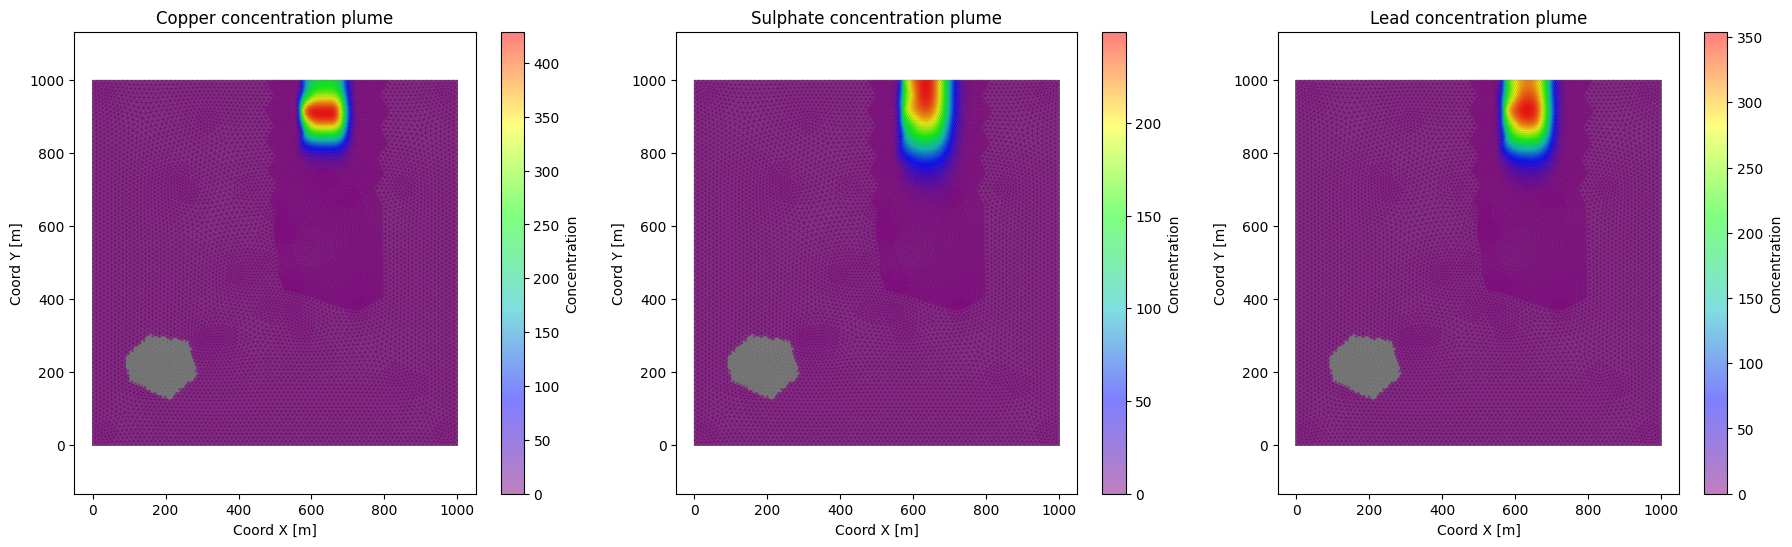

In [21]:
# Visualise and inspect the final transient results
# Create a new matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,6))

for ax, name in [(ax1, "Copper"), (ax2, "Sulphate"), (ax3, "Lead")]:
    plt.sca(ax)
    # Set equal x and y axis
    plt.axis("equal")
    # Add the mesh (faces and edges)
    doc.c.plot.faces()
    doc.c.plot.edges(alpha=0.1)
    # Add the observation points (If using run all in jupyter, do this afterwards, hangs for some reason)
    #doc.c.plot.obs_markers()
    #doc.c.plot.obs_labels()
    doc.c.plot.continuous(par=(Enum.P_CONC, name), slice=1, alpha=0.5, vmin=0)

    # Add colorbar, title and axis labels
    cbar = plt.colorbar()
    cbar.set_label('Concentration', rotation=90)
    plt.title(f"{name} concentration plume")
    plt.xlabel("Coord X [m]")
    plt.ylabel("Coord Y [m]")

# Plot
plt.show()

In [22]:
history_items = [i for i in dir(Enum) if i.startswith("HIST_")]
history_items

['HIST_ANA',
 'HIST_AVER_H',
 'HIST_AVER_M',
 'HIST_BHE',
 'HIST_BHE_IO',
 'HIST_CONTENT_AGE',
 'HIST_CONTENT_ENERGY',
 'HIST_CONTENT_EP',
 'HIST_CONTENT_HEAT',
 'HIST_CONTENT_MASS',
 'HIST_CONTENT_VOLUME',
 'HIST_CONTENT_VOLUME_MASS',
 'HIST_FFLUX',
 'HIST_FFLUX_I',
 'HIST_HEAD',
 'HIST_HFLUX',
 'HIST_HFLUX_I',
 'HIST_IFM',
 'HIST_ITERA',
 'HIST_LOCA_H',
 'HIST_LOCA_M',
 'HIST_MFLUX',
 'HIST_MFLUX_I',
 'HIST_MULTW_FLUX',
 'HIST_RESIDUAL',
 'HIST_TIMES',
 'HIST_VARIO']

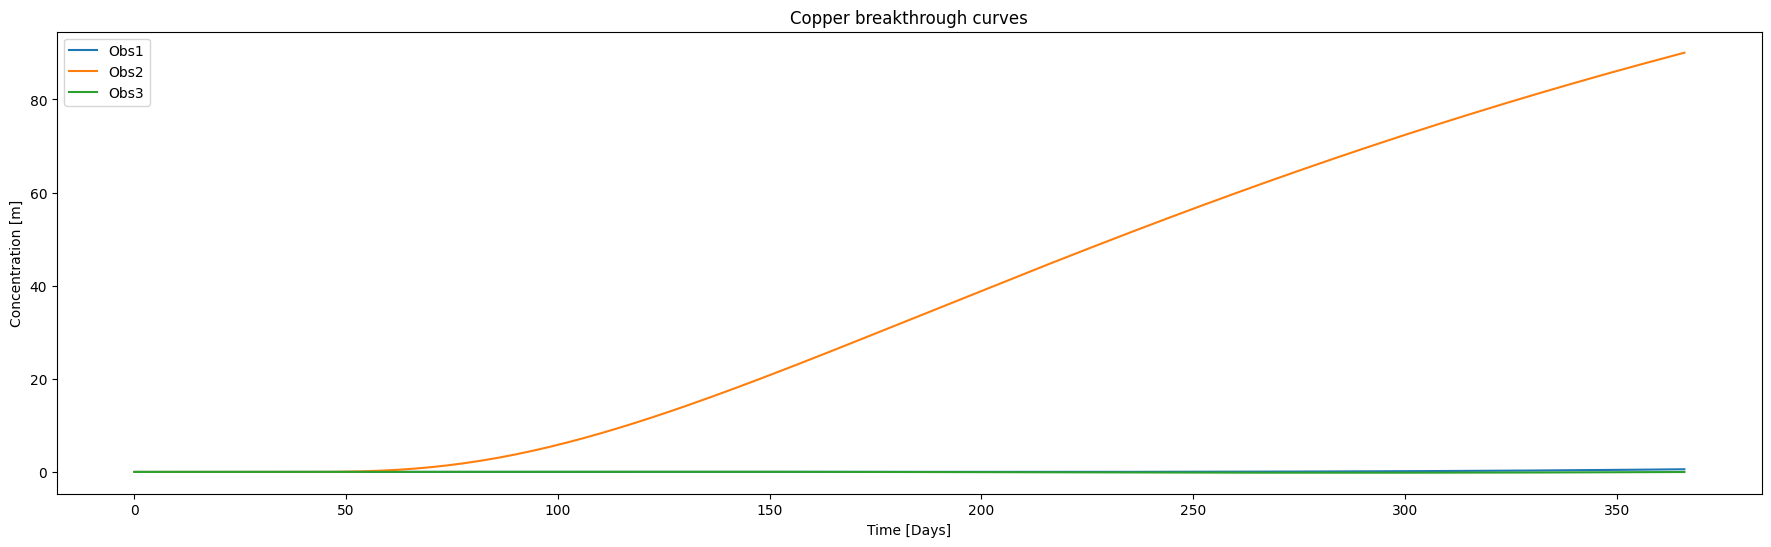

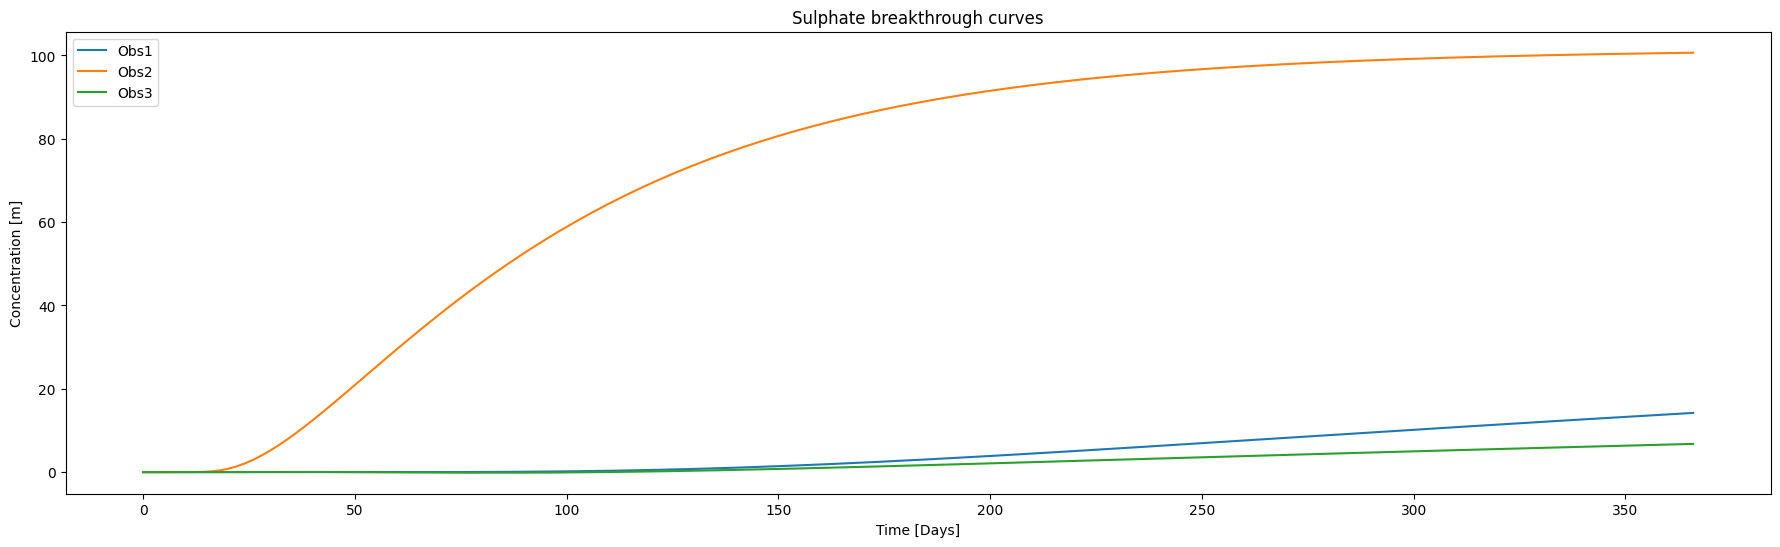

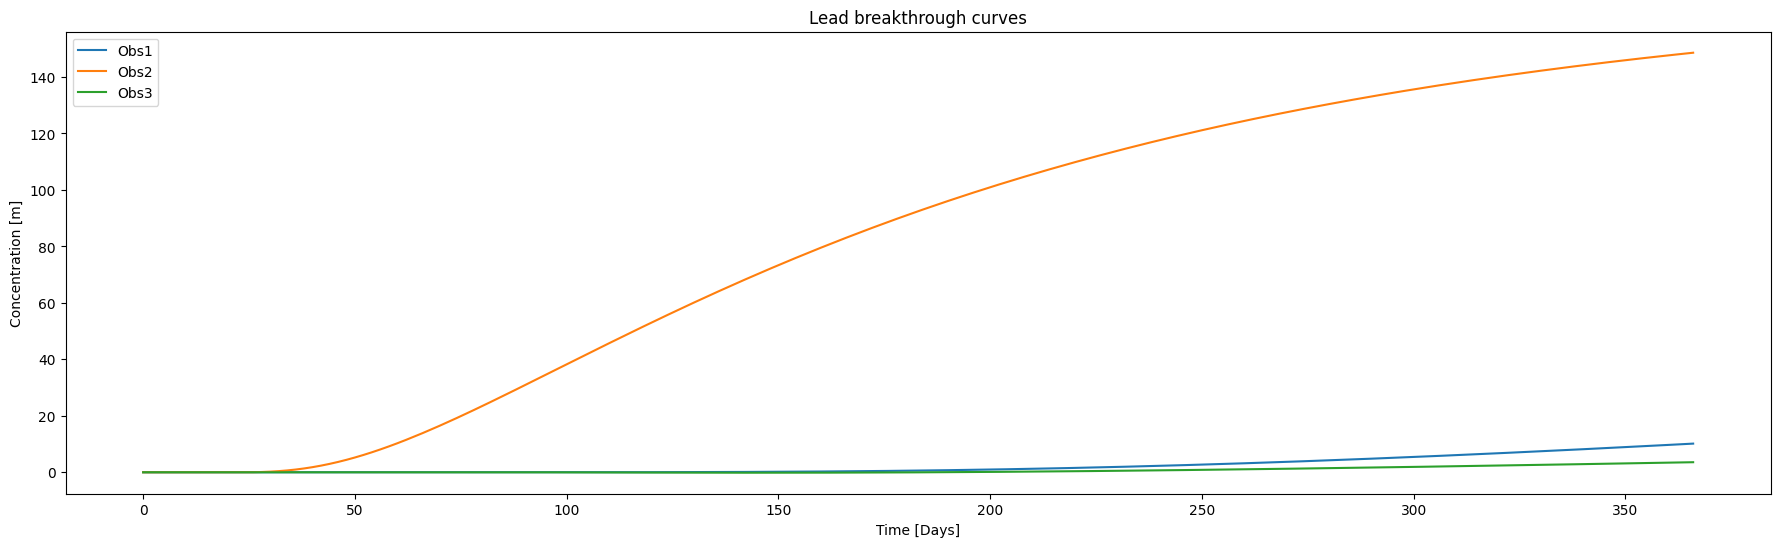

In [23]:
for species in range(doc.getNumberOfSpecies()):
    # Get the name and history values of each species
    name = doc.getSpeciesName(species)
    hist_time, hist_values, hist_labels = doc.getHistoryValues(Enum.HIST_LOCA_M, species)
    # Create a dictionary
    dict_hist = {"Time": hist_time}
    # Create a figure
    hist_fig, hist_ax = plt.subplots(1, 1, figsize=(22,6))
    # Loop through the species
    for hist_index in range(len(hist_labels)):
        # Plot the curve for each observation point
        hist_ax.plot(hist_time, hist_values[hist_index], label=hist_labels[hist_index])
        # Add the data to the dictionary
        dict_hist[hist_labels[hist_index]] = hist_values[hist_index]
    # Show the legend
    hist_ax.legend()
    # Add the necessities
    plt.title(f"{name} breakthrough curves")
    plt.xlabel("Time [Days]")
    plt.ylabel("Concentration [m]")
    # Save
    plt.savefig(os.path.join(os.path.join(os.getcwd(), "output"), f"{name}BreakthroughCurves.png"))
    # Transform the values to a dataframe
    df_hist = pd.DataFrame(dict_hist)
    df_hist.to_excel(os.path.join(os.path.join(os.getcwd(), "output"), f"{name}BreakthroughCurves.xlsx"))

In [24]:
# Stop the simulation
doc.stopSimulator()
# And save the FEM results
doc.saveDocument(os.path.join(os.path.join(os.getcwd(), "fem"), "ModelModTransResults.fem"))

If we want to change the settings for each species, we can do it as follows:

In [25]:
# Kinetics type
print(doc.getSpeciesKineticsType(0))
print(doc.getSpeciesKineticsType(1))
print(doc.getSpeciesKineticsType(2))

print(doc.getSpeciesKineticsDegradation(0))

0
0
0
[[1.0], [1.0]]


In [26]:
# Degradation
doc.setSpeciesKineticsDegradation(0, [1.1], [1.1])
print(doc.getSpeciesKineticsType(0))
print(doc.getSpeciesKineticsDegradation(0))

0
[[1.1], [1.1]]


In [27]:
# Arrhenius
doc.setSpeciesKineticsArrhenius(1, [1.1, 1.1])
print(doc.getSpeciesKineticsType(1))
print(doc.getSpeciesKineticsArrhenius(1))

1
[[1.1, 1.1], [1.0, 1.0]]


In [28]:
# Monod
doc.setSpeciesKineticsMonod(2, [1.1, 1.1, 1.1], [1.2, 1.2, 1.2, 1.2], [1.3, 1.3, 1.3, 1.3, 1.3, 1.3], 
                            [1.4, 1.4, 1.4, 1.4, 1.4, 1.4], [1.5, 1.5, 1.5, 1.5, 1.5, 1.5])
print(doc.getSpeciesKineticsType(2))
print(doc.getSpeciesKineticsMonod(2))

2
[[1.1, 1.1, 1.1], [1.2, 1.2, 1.2, 1.2], [1.3, 1.3, 1.3, 1.3, 1.3, 1.3], [1.4, 1.4, 1.4, 1.4, 1.4, 1.4], [1.5, 1.5, 1.5, 1.5, 1.5, 1.5]]


Lastly, it is very important to close the FEM file once the operations are complete!

In [29]:
# Close the FEM file
doc.closeDocument()